In [7]:
# import required packages, though not all of them are actually used
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.mlab as mlab
import matplotlib.dates as mpl_dates
%matplotlib inline

# set fig size; bigger DPI results in bigger fig
plt.rcParams["figure.dpi"] = 100

import seaborn as sns
import pandas as pd
import numpy as np
import sympy as sp
import math
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import curve_fit
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels.stats.outliers_influence as sso
from statsmodels.stats.stattools import durbin_watson as sdw
import statsmodels.stats.libqsturng
import plotly.express as px
from datetime import datetime
 

import random
import itertools
import math

plt.style.use('ggplot') # refined style


In [8]:
def percentile(data, percentage):
    """
    Will return the value corresponding to the percentile from the data.

    Difference from numpy.percentile: this function will perform a (n + 1) instead of (n) only
    """
    if type(data) == np.ndarray:
        all_data = data.copy()
        data = data.copy()
    else:
        all_data = data.values.copy()
        data = data.values.copy()
    all_data.sort()
    n = all_data.size
    l = (n + 1) * percentage / 100 - 1

    f_l = math.floor(l)
    c_l = math.ceil(l)

    percentile_val = all_data[f_l] + \
        (all_data[c_l] - all_data[f_l]) * (l - f_l)

    return percentile_val


def percentrank(data, value):
    """
    Will return the corresponding percentile rank given the value.
    """
    if type(data) == np.ndarray:
        all_data = data.copy()
        data = data.copy()
    else:
        all_data = data.values.copy()
        data = data.values.copy()
    all_data.sort()
    l = np.searchsorted(all_data, value, side='left') + 1
    n = all_data.size
    percentage = l * 100 / (n + 1)
    return percentage
def interval(df):
    upl_1 = round(df.mean() + df.std(), 4)
    upl_2 = round(df.mean() + 2 * df.std(), 4)
    upl_3 = round(df.mean() + 3 * df.std(), 4)
    lowl_1 = round(df.mean() - df.std(), 4)
    lowl_2 = round(df.mean() - 2 * df.std(), 4)
    lowl_3 = round(df.mean() - 3 * df.std(), 4)
    result = f"""1 std limits = ({lowl_1}, {upl_1})
2 std limits = ({lowl_2}, {upl_2})
3 std limits = ({lowl_3}, {upl_3})
    """
    print(result)


def quartiles(data, show=False):
    """
    default show = False

    Return Q1, Q2, Q3, IQR
    """
    Q1 = percentile(data, 25)
    Q2 = percentile(data, 50)
    Q3 = percentile(data, 75)
    IQR = Q3 - Q1  # IQR is interquartile range.
    description = """
Q1 = {}
Q2 = {}
Q3 = {}
IQR = {}
    """.format(Q1, Q2, Q3, IQR)
    if show:
        print(description)

    return Q1, Q2, Q3, IQR


def outlier(data, show=True):
    """
    The default is set to per.percentile()
    default show = True

    Return a list of outliers and description

    Usages
    ------
    >>> df = whatever DataFrame you construct
    # to use per.percentile (textbook) to compute quartiles
    >>> per.outlier(df["column_name"], per)
    # to use np.percentile to compute quartiles
    >>> per.outlier(df["column_name"], np)

    Examples
    ------
    In HW04, 4.73, the results could be different:
    >>> per.outlier(df["Time_Public"].dropna(), np)
    Quartiles for playing on a public course:

    Q1 = 279.5
    Q2 = 296.0
    Q3 = 307.0
    IQR = 27.5

    Outliers are listed as follows:
    [238.0, 359.0]

    >>> per.outlier(df["Time_Public"].dropna()) # default = per
    Quartiles for playing on a public course:

    Q1 = 279.0
    Q2 = 296.0
    Q3 = 307.0
    IQR = 28.0

    Outliers are listed as follows:
    [359.0]

    """
    # Q1 = base.percentile(data, 25)
    # Q2 = base.percentile(data, 50)
    # Q3 = base.percentile(data, 75)
    # IQR = Q3 - Q1  # IQR is interquartile range.
    Q1, Q2, Q3, IQR = quartiles(data)
    filter = (data < Q1 - 1.5 * IQR) | (data > Q3 + 1.5 * IQR)
    if (len(data.loc[filter].to_list()) != 0):
        outlier_prompt = "Outliers are listed as follows:\n{}".format(
            data.loc[filter].to_list())
    else:
        outlier_prompt = "There are no outliers."

    description = """
Q1 = {}
Q2 = {}
Q3 = {}
IQR = {}

{}
    """.format(Q1, Q2, Q3, IQR, outlier_prompt)
    if show:
        print(description)

    if (len(data.loc[filter].to_list()) != 0):
        return data.loc[filter].to_list(), description
    else:
        return list(), description

def mav(df, n, y_name, time_name, weight: list = None):
    """
    """
    ma_p_a = np.zeros(df.shape[0] + 1)
    y_v = df[y_name].dropna().values
    ma_p_a[:] = np.nan
    for i in range(n, len(ma_p_a)):
        if weight is not None:
            ma_p_a[i] = np.sum(y_v[i-n: i] * np.array(weight))
        else:
            ma_p_a[i] = np.mean(y_v[i-n: i])
    t1 = np.append(df[time_name].dropna().values[:len(y_v)], [
                   df[time_name].dropna().values[:len(y_v)][-1] + 1])

    ma_df_p = pd.DataFrame(
        {time_name: t1, y_name: np.append(y_v, [np.nan]), f'MA({n})': ma_p_a})
    return pd.concat([ma_df_p, df.drop(columns=[time_name, y_name])], axis=1)


def exp_smoothing(df, alpha, y_name, time_name):
    y_v = df[y_name].dropna().values
    es_df = pd.DataFrame({'orig': y_v})
    es_df['es_res'] = es_df['orig'].ewm(alpha=alpha, adjust=False).mean()
    es_al_a = np.zeros(len(y_v) + 1)
    es_al_a[0] = es_df['es_res'][0]
    es_al_a[1] = es_df['es_res'][0]
    for i in range(2, len(y_v) + 1):
        es_al_a[i] = es_df['es_res'][i-1]
    t1 = np.append(df[time_name].dropna().values[:len(y_v)], [
                   df[time_name].dropna().values[:len(y_v)][-1] + 1])
    org_data = y_v.tolist()
    es_df_e = pd.DataFrame(
        {time_name: t1, y_name: np.append(y_v, [np.nan]), f'ES({alpha})': es_al_a})
    return pd.concat([es_df_e, df.drop(columns=[time_name, y_name])], axis=1)


def exp_trend(df, alpha, beta, average, trend, n=2, y_name="", time_name="", drop=True):
    """
    """
    from statsmodels.tsa.api import Holt
    import statsmodels.api as sm

    y_v = df[y_name].dropna().values
    esm_a = np.array(y_v)
    esm_model = Holt(esm_a, initialization_method='known', initial_level=average, initial_trend=trend).fit(
        smoothing_level=alpha, smoothing_trend=beta, optimized=False)
    esm_fit = esm_model.fittedvalues
    esm_fcast = esm_model.forecast(n)
    esm_ab_a = np.zeros(len(y_v) + n + 1)
    esm_ab_a[0] = average + trend
    for i in range(1, len(y_v) + 1):
        esm_ab_a[i] = esm_fit[i-1]
    for i in range(len(y_v) + 1, len(y_v) + n + 1):
        esm_ab_a[i] = esm_fcast[i-len(y_v)-1]

    Ini_v = average + trend
    if drop:
        t1 = np.append(df[time_name].dropna().values[:len(y_v)], [
            df[time_name].dropna().values[:len(y_v)][-1] + i for i in range(1, n + 1)])
        org_data = np.append(y_v, [np.nan]*n)
        wsm_df_ab = pd.DataFrame(
            {time_name: t1, f'{y_name}': org_data, f'EST({alpha}, {beta}, {average}, {trend})': esm_ab_a[1:]})
        old_df = df.drop(columns=[time_name, y_name])
        # na_df = pd.DataFrame(
        #     [[np.nan for i in range(len(old_df.columns))]], columns=old_df.columns)
        # old_df = pd.concat([na_df, old_df], ignore_index=True)
        for i in range(n):
            na_df = pd.DataFrame(
                [[np.nan for i in range(len(old_df.columns))]], columns=old_df.columns)
            old_df = pd.concat([old_df, na_df], ignore_index=True)
    else:
        t1 = np.append(df[time_name].dropna().values[:len(y_v)], [
            df[time_name].dropna().values[:len(y_v)][-1] + i for i in range(1, n + 2)])
        W_ini_v = np.append(Ini_v, y_v)
        org_data = np.append(W_ini_v, [np.nan]*n)
        wsm_df_ab = pd.DataFrame(
            {time_name: t1, f'{y_name}': org_data, f'EST({alpha}, {beta}, {average}, {trend})': esm_ab_a[:]})
        old_df = df.drop(columns=[time_name, y_name])
        na_df = pd.DataFrame(
            [[np.nan for i in range(len(old_df.columns))]], columns=old_df.columns)
        old_df = pd.concat([na_df, old_df], ignore_index=True)
        for i in range(n):
            na_df = pd.DataFrame(
                [[np.nan for i in range(len(old_df.columns))]], columns=old_df.columns)
            old_df = pd.concat([old_df, na_df], ignore_index=True)

    return pd.concat([wsm_df_ab, old_df], axis=1)


def error_metric(y=None, pred_y=None, df: pd.DataFrame = None, measurements: list = None, y_name: str = '', precision=4):
    def compute_error(y, pred_y):
        raw_err = np.array(y - pred_y)
        err = raw_err[~np.isnan(raw_err)]
        raw_percentage = np.array((y - pred_y) / y)
        err_percentage = raw_percentage[~np.isnan(raw_percentage)]

        MAD = np.absolute(err).mean()
        MSE = np.mean(err * err)
        RMSE = np.sqrt(np.mean(err * err))
        MAPE = np.absolute(err_percentage).mean() * 100

        err_dict = {'MAD': MAD, 'MSE': MSE, 'RMSE': RMSE, 'MAPE': MAPE}

        return err_dict

    if measurements is None:

        err_dict = compute_error(y, pred_y)

        result = f"""======= Error Metrics =======
MAD = {err_dict['MAD']:.{precision}f}
MSE = {err_dict['MSE']:.{precision}f}
RMSE = {err_dict['RMSE']:.{precision}f}
MAPE = {err_dict['MAPE']:.{precision}f}%
"""
        print(result)
        return err_dict
    else:
        err_df = pd.DataFrame(columns=measurements, index=[
                              'MAD', 'MSE', 'RMSE', 'MAPE'])
        df = df.dropna()
        for measurement in measurements:
            y = df[y_name]
            pred_y = df[measurement]
            err_dict = compute_error(y, pred_y)

            result = f"""### Error Metrics - {measurement}
MAD = {err_dict['MAD']:.{precision}f}
MSE = {err_dict['MSE']:.{precision}f}
RMSE = {err_dict['RMSE']:.{precision}f}
MAPE = {err_dict['MAPE']:.{precision}f}%
"""
            print(result)

            err_df[measurement] = list(err_dict.values())

        min_val = err_df.min(axis=1).values

        def _highlight(val):
            color = 'lightgreen' if val in min_val else 'default'
            return 'background-color: %s' % color

        style_df = err_df.style.applymap(_highlight)

        return err_df, style_df


In [9]:
df1 = pd.read_csv('110.csv')
df2 = pd.read_csv('110.csv')
df3 = pd.read_csv('110.csv')
# Concat
dfc = pd.concat([df1,df2,df3])
dfc.reset_index(drop=True, inplace=True)
print('Head of dataset:')
display(dfc.head())

print("Tail of dataset:")
display(dfc.tail())

Head of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
0,1月1日,168.20,318.524,0.0,"1,109,556","1,289,556","-180,000","2,475,360","3,764,916"
1,1月2日,168.18,318.419,3.8,"974,520","614,520","360,000","2,221,200","2,835,720"
2,1月3日,168.22,318.741,0.4,"817,460","458,460","359,000","2,328,120","2,786,580"
3,1月4日,168.23,318.887,16.1,"1,168,992","1,168,992",0,"2,098,080","3,267,072"
4,1月5日,168.30,319.450,20.7,"2,306,772","2,126,772","180,000","2,324,880","4,451,652"


Tail of dataset:


,日期,翡翠水庫日平均水位/公尺,水庫有效蓄水量/百萬立方公尺,集水區平均雨量/毫米,水庫進流量/立方公尺,水庫放流量/立方公尺,進流量減放流量/立方公尺,南勢溪流量/立方公尺,南北勢溪合計原水量/立方公尺
1090,12月27日,168.07,317.416,13.6,"4,729,660","4,101,660","628,000","2,787,480","6,889,140"
1091,12月28日,168.15,318.109,1.1,"3,473,152","2,575,152","898,000","2,765,520","5,340,672"
1092,12月29日,168.22,318.749,0.4,"2,310,048","2,130,048","180,000","2,468,160","4,598,208"
1093,12月30日,168.20,318.502,0.2,"1,857,808","2,396,808","-539,000","2,243,520","4,640,328"
1094,12月31日,168.16,318.232,1.4,"1,244,456","615,456","629,000","2,050,560","2,666,016"


In [10]:
df_new = pd.DataFrame({'day':pd.Series(range(1,1096)),'flow':dfc['水庫進流量/立方公尺']})
for i in range(1095):
    df_new['flow'][i] = float(df_new['flow'][i].replace(",",""))
display(df_new)

<ipython-input-10-f50454eb11f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['flow'][i] = float(df_new['flow'][i].replace(",",""))


,day,flow
0,1,1.10956e+06
1,2,974520
2,3,817460
3,4,1.16899e+06
4,5,2.30677e+06
...,...,...
1090,1091,4.72966e+06
1091,1092,3.47315e+06
1092,1093,2.31005e+06
1093,1094,1.85781e+06


,day,flow,MA(3),ES(0.8),"EST(0.8, 0.2, 1109556.0, 1)",Regression
0,1,1.10956e+06,NaN,1.109556e+06,1.109557e+06,1.919183e+06
1,2,974520,NaN,1.109556e+06,1.109557e+06,1.920089e+06
2,3,817460,NaN,1.001527e+06,9.799223e+05,1.920995e+06
3,4,1.16899e+06,9.671787e+05,8.542734e+05,8.023534e+05,1.921900e+06
4,5,2.30677e+06,9.869907e+05,1.106048e+06,1.106727e+06,1.922805e+06
...,...,...,...,...,...,...
1091,1092,3.47315e+06,3.821808e+06,4.636274e+06,5.287576e+06,2.644738e+06
1092,1093,2.31005e+06,4.371589e+06,3.705776e+06,4.085927e+06,2.645162e+06
1093,1094,1.85781e+06,3.504287e+06,2.589194e+06,2.630973e+06,2.645585e+06
1094,1095,1.24446e+06,2.547003e+06,2.004085e+06,1.854484e+06,2.646008e+06


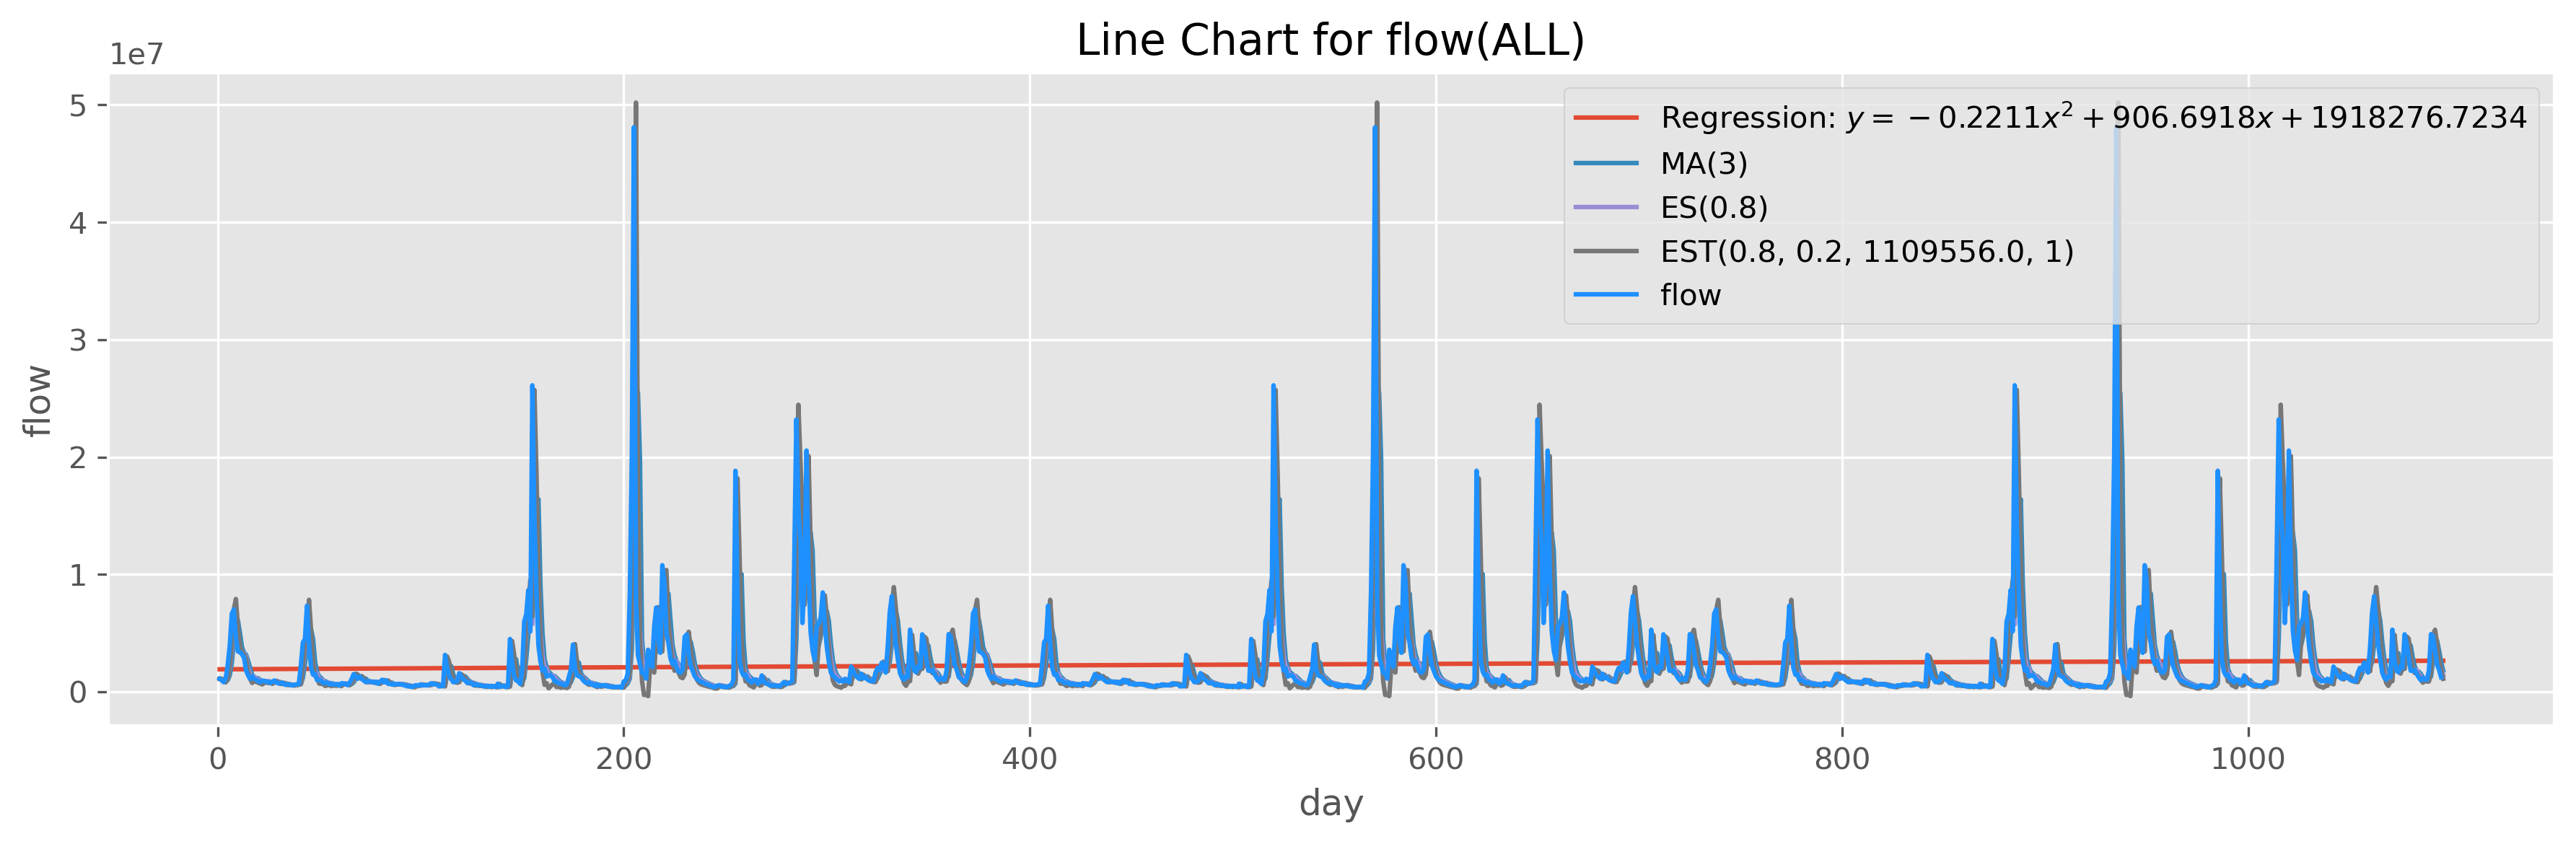

In [11]:
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize = (12,4))
y_name="flow"
x_name="day"
y_var = df_new[y_name].values
x_var = df_new[x_name].values
y_var = y_var.astype('float64')
# MA
forecast_df = mav(df_new, 3, y_name=y_name, time_name=x_name)
# exp smoothin
alpha = 0.8
forecast_df = forecast_df.merge(exp_smoothing(df=df_new, alpha=alpha, y_name=y_name, time_name=x_name))
# exp trend
forecast_df = forecast_df.merge(exp_trend(df=df_new, alpha=0.8, beta=0.2, average=y_var[0], trend=1, n=2, y_name=y_name, time_name=x_name))

# regression
fitParams = np.polyfit(x_var, y_var, 2)
a, b, c = fitParams
forecast_df['Regression'] = np.polyval(fitParams, list(forecast_df[x_name]))
# Plot
f_col = ['MA(3)', 'ES(0.8)', 'EST(0.8, 0.2, 1109556.0, 1)']

label = f'Regression: $y = {a:.4f} x^2 + {b:.4f} x + {c:.4f}$'
x_line = forecast_df[x_name].values
y_line = np.polyval(fitParams, x_line)
plt.plot(x_line, y_line, label=label)

for f in f_col:
    y_line = forecast_df[f][:len(x_line)]
    plt.plot(x_line, y_line, label=f)

display(forecast_df)

# data

plt.plot(x_var, y_var, color='dodgerblue', label='flow')
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.legend()
plt.title('Line Chart for flow(ALL)') 
fig.tight_layout()


plt.show()

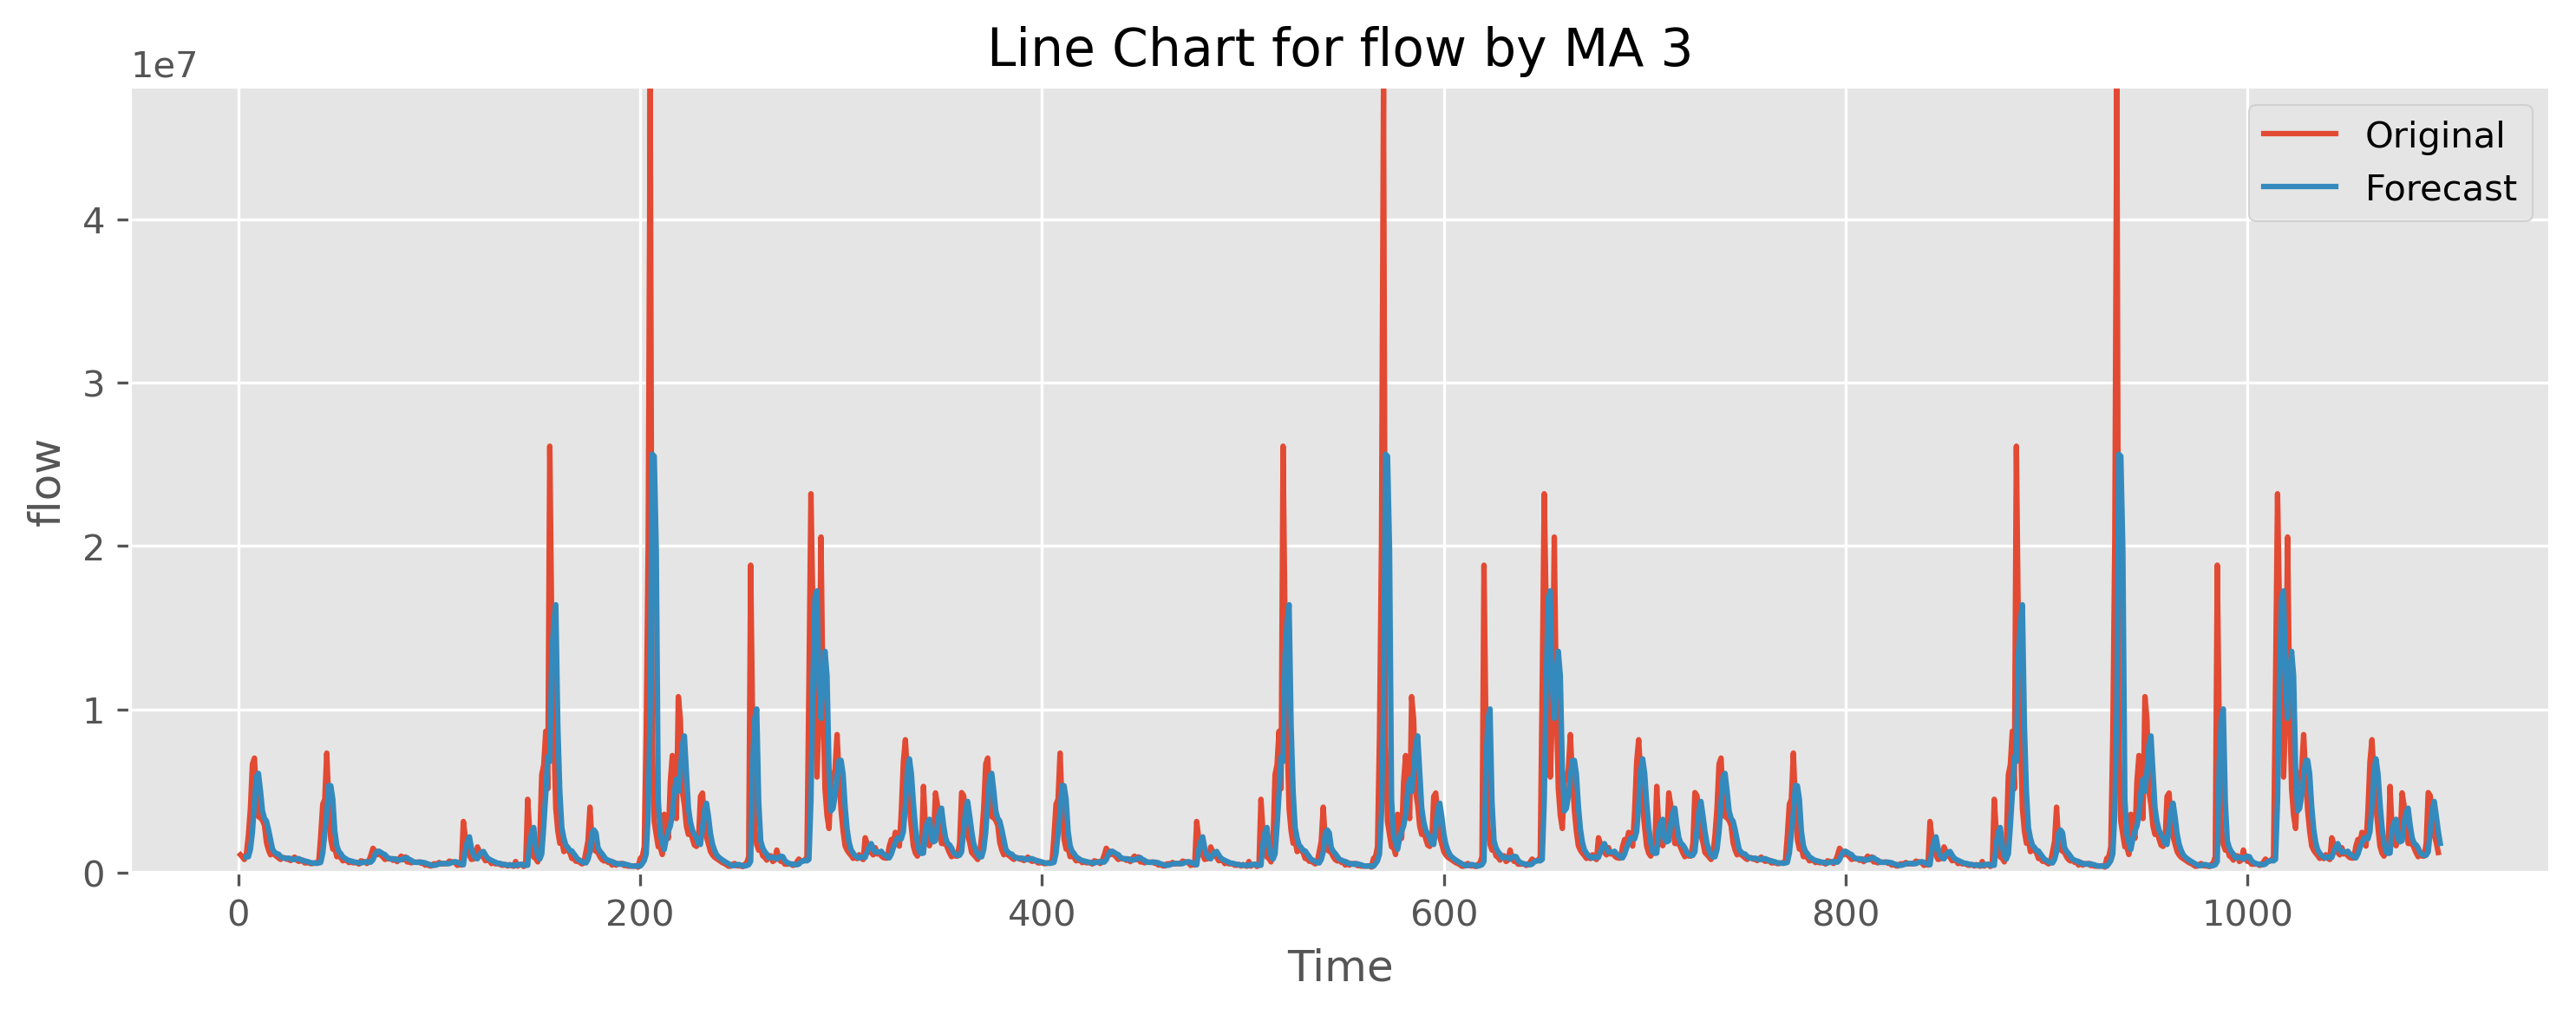

In [12]:
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize = (12,4))
plt.plot(forecast_df['day'], forecast_df['flow'], label='Original')
plt.plot(forecast_df['day'], forecast_df['MA(3)'], label='Forecast')

plt.ylim(0, max(forecast_df[y_name])+5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('flow')
plt.title('Line Chart for flow by MA 3')
plt.show()

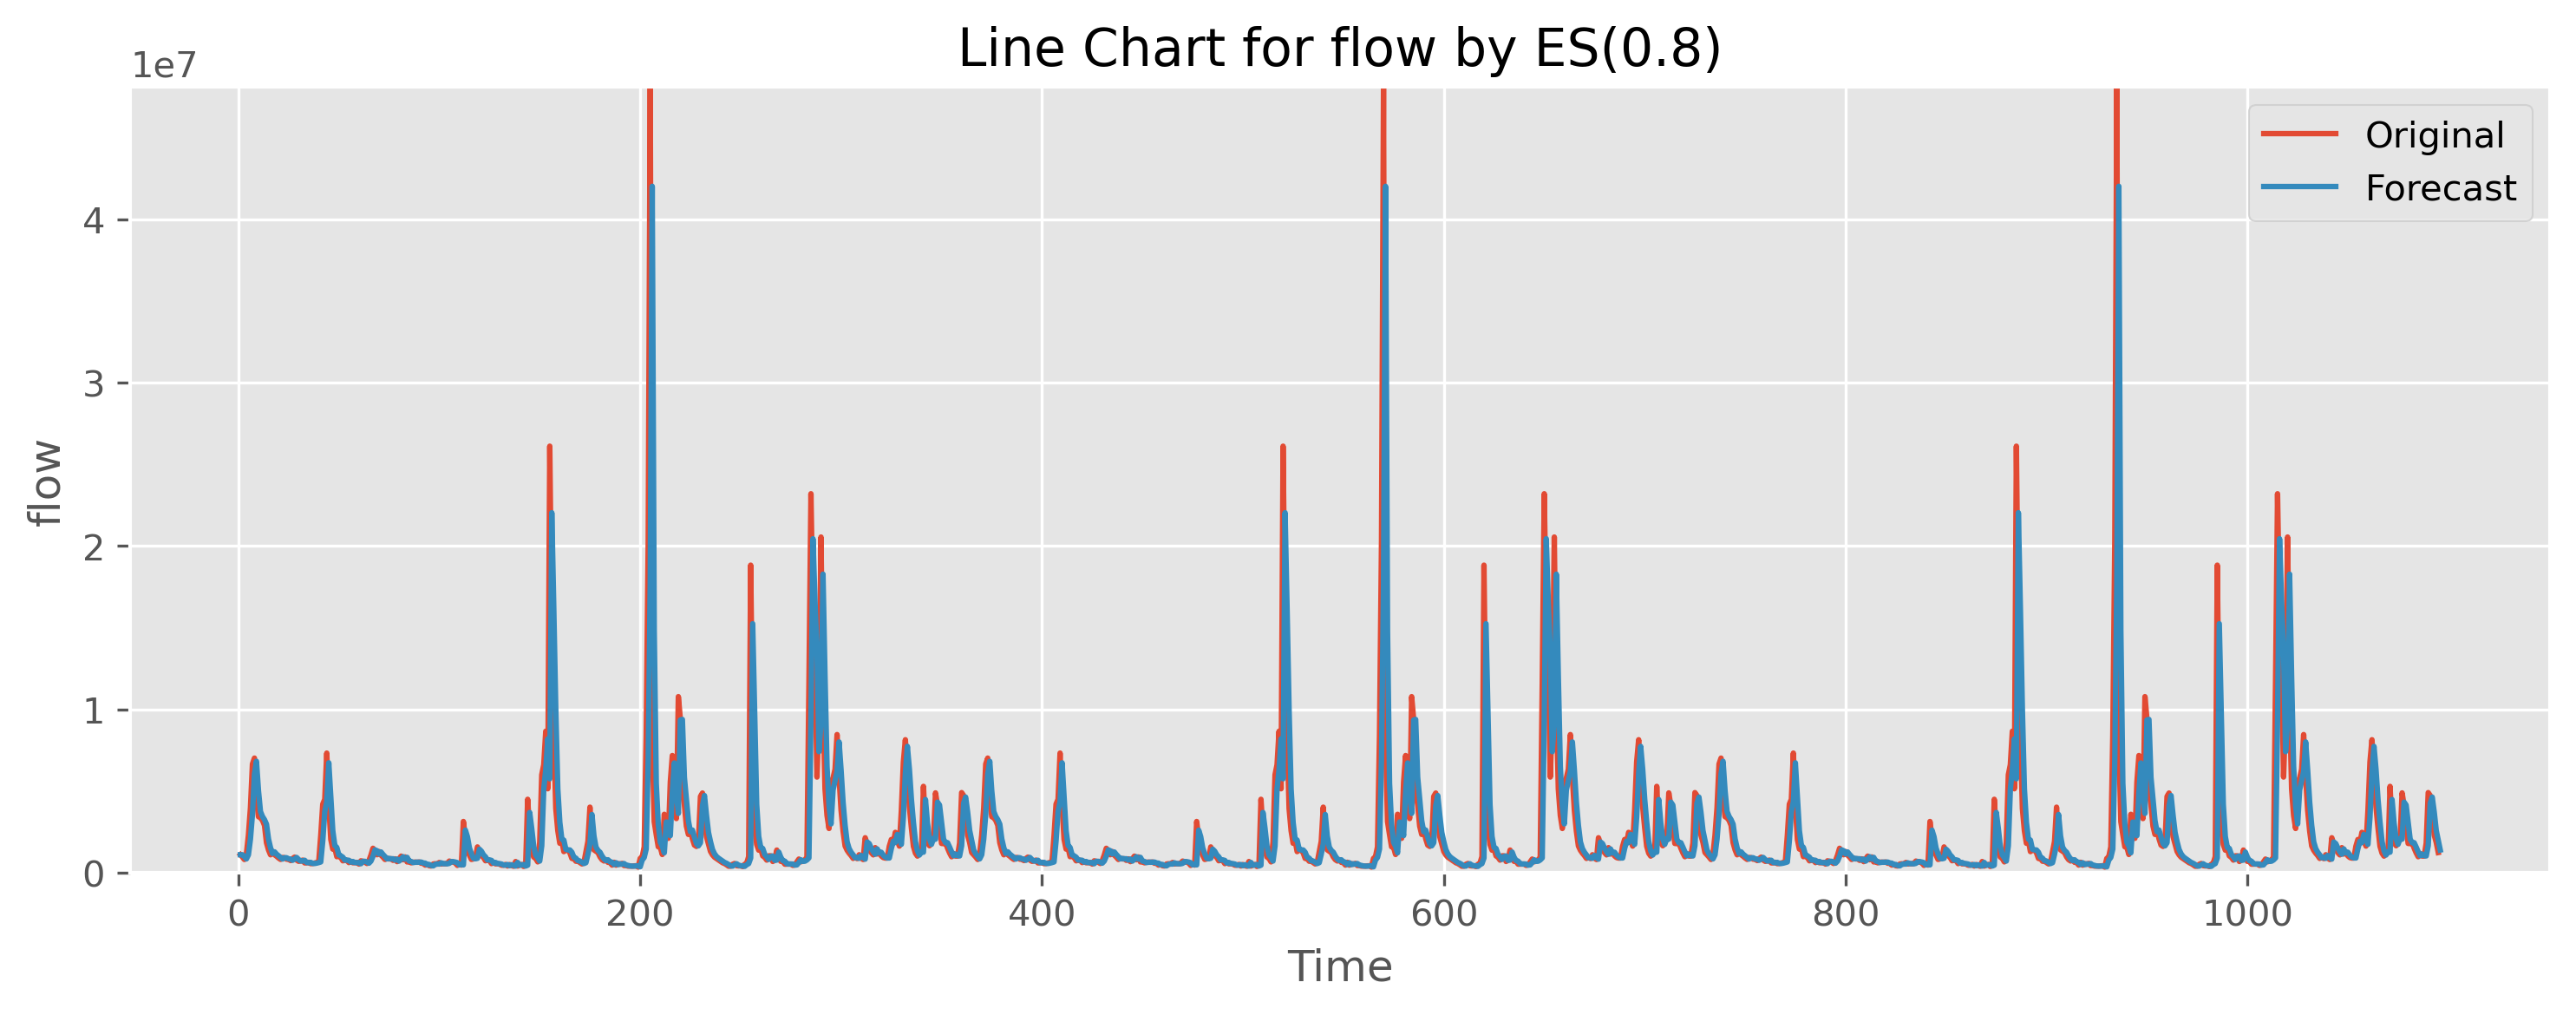

In [13]:
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize = (12,4))
plt.plot(forecast_df['day'], forecast_df['flow'], label='Original')
plt.plot(forecast_df['day'], forecast_df['ES(0.8)'], label='Forecast')

plt.ylim(0, max(forecast_df[y_name])+5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('flow')
plt.title('Line Chart for flow by ES(0.8)')
plt.show()

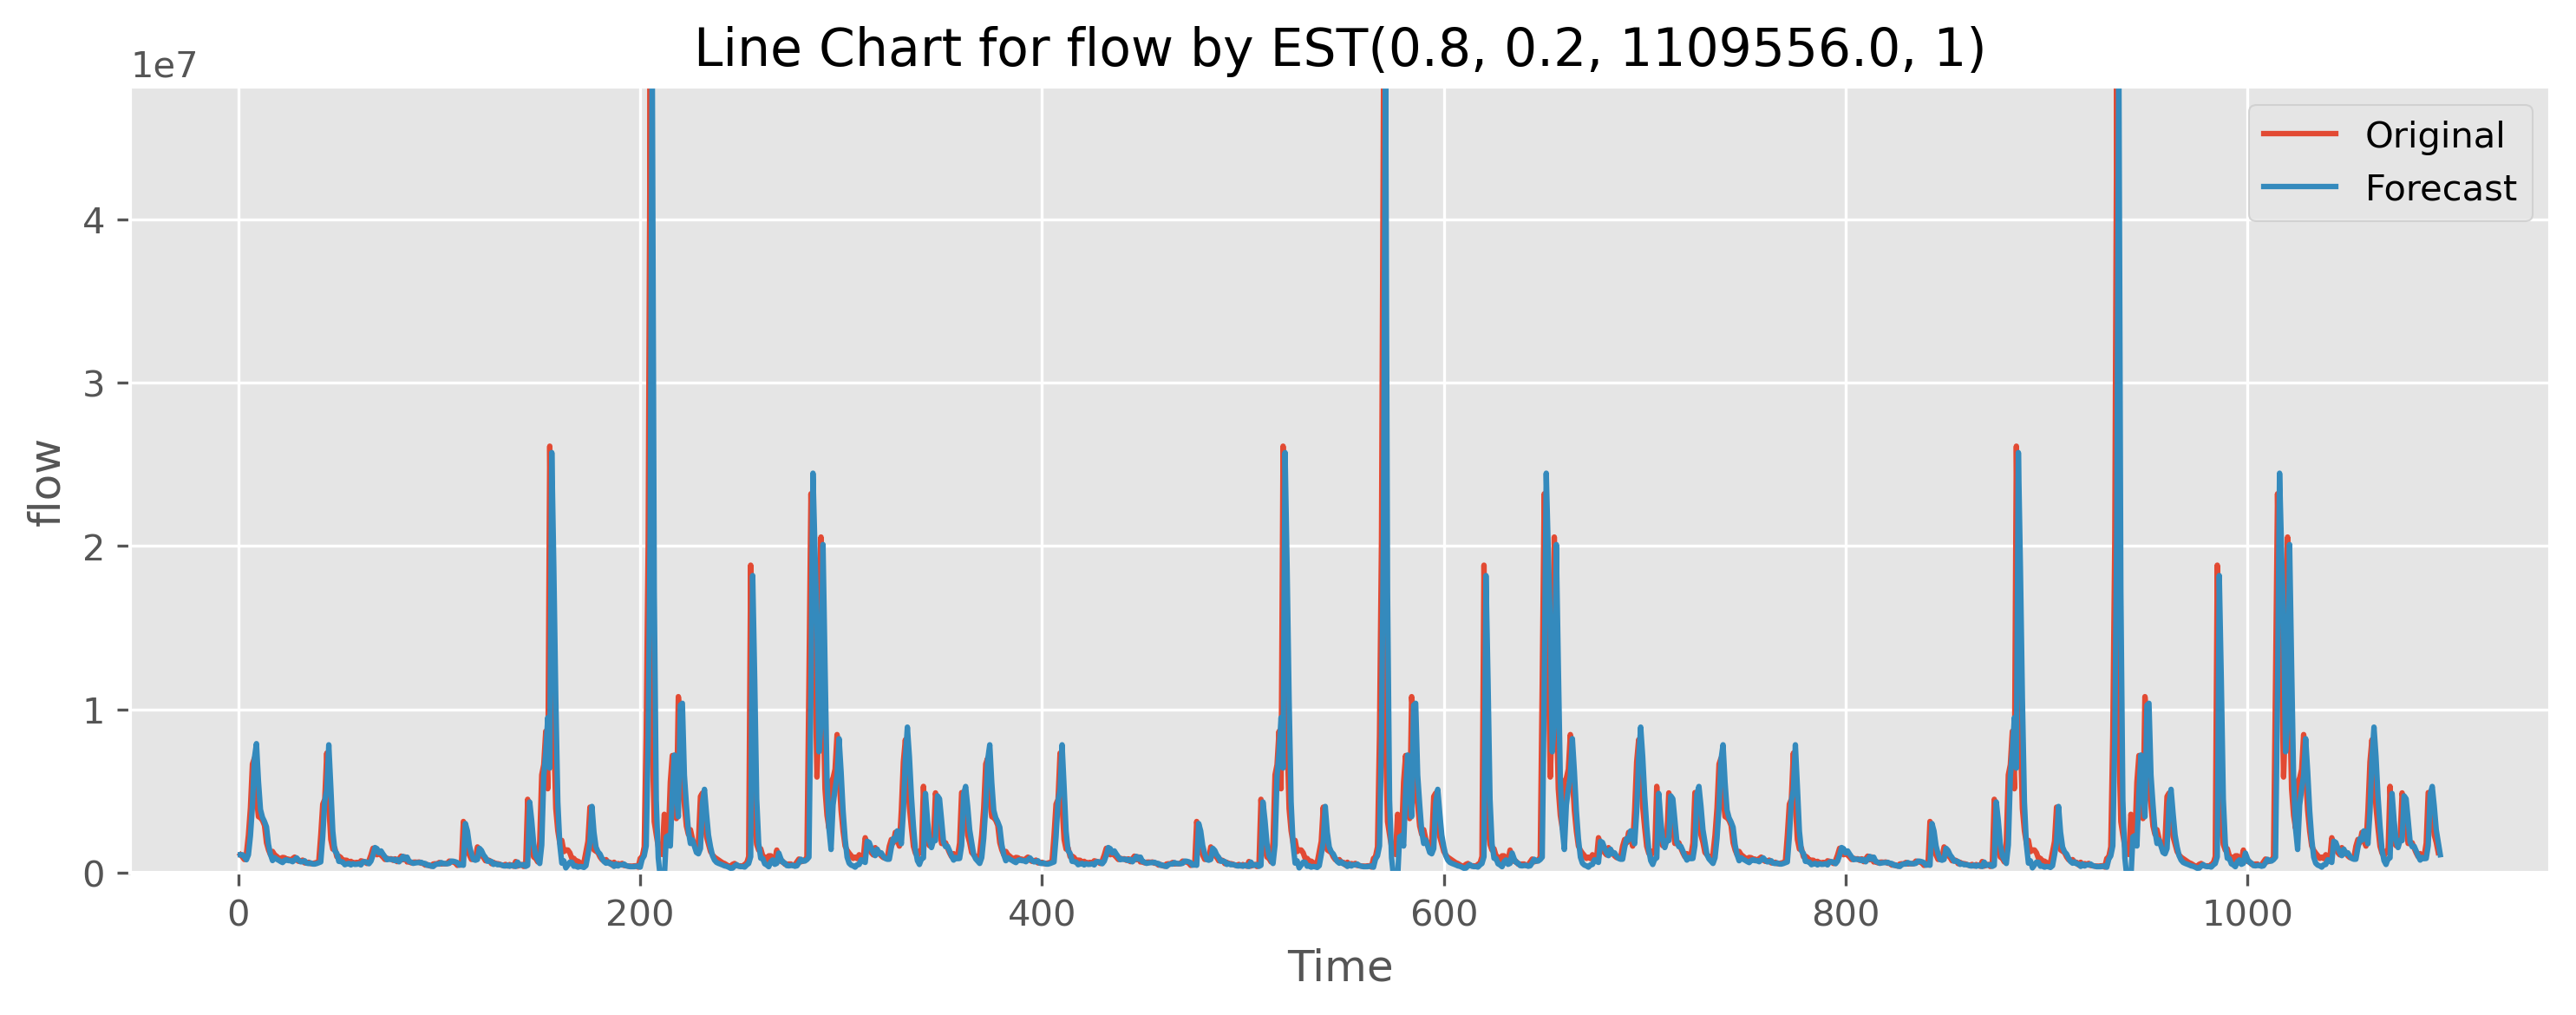

In [14]:
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize = (12,4))
plt.plot(forecast_df['day'], forecast_df['flow'], label='Original')
plt.plot(forecast_df['day'], forecast_df['EST(0.8, 0.2, 1109556.0, 1)'], label='Forecast')

plt.ylim(0, max(forecast_df[y_name])+5)
plt.legend()
plt.xlabel('Time')
plt.ylabel('flow')
plt.title('Line Chart for flow by EST(0.8, 0.2, 1109556.0, 1)')
plt.show()

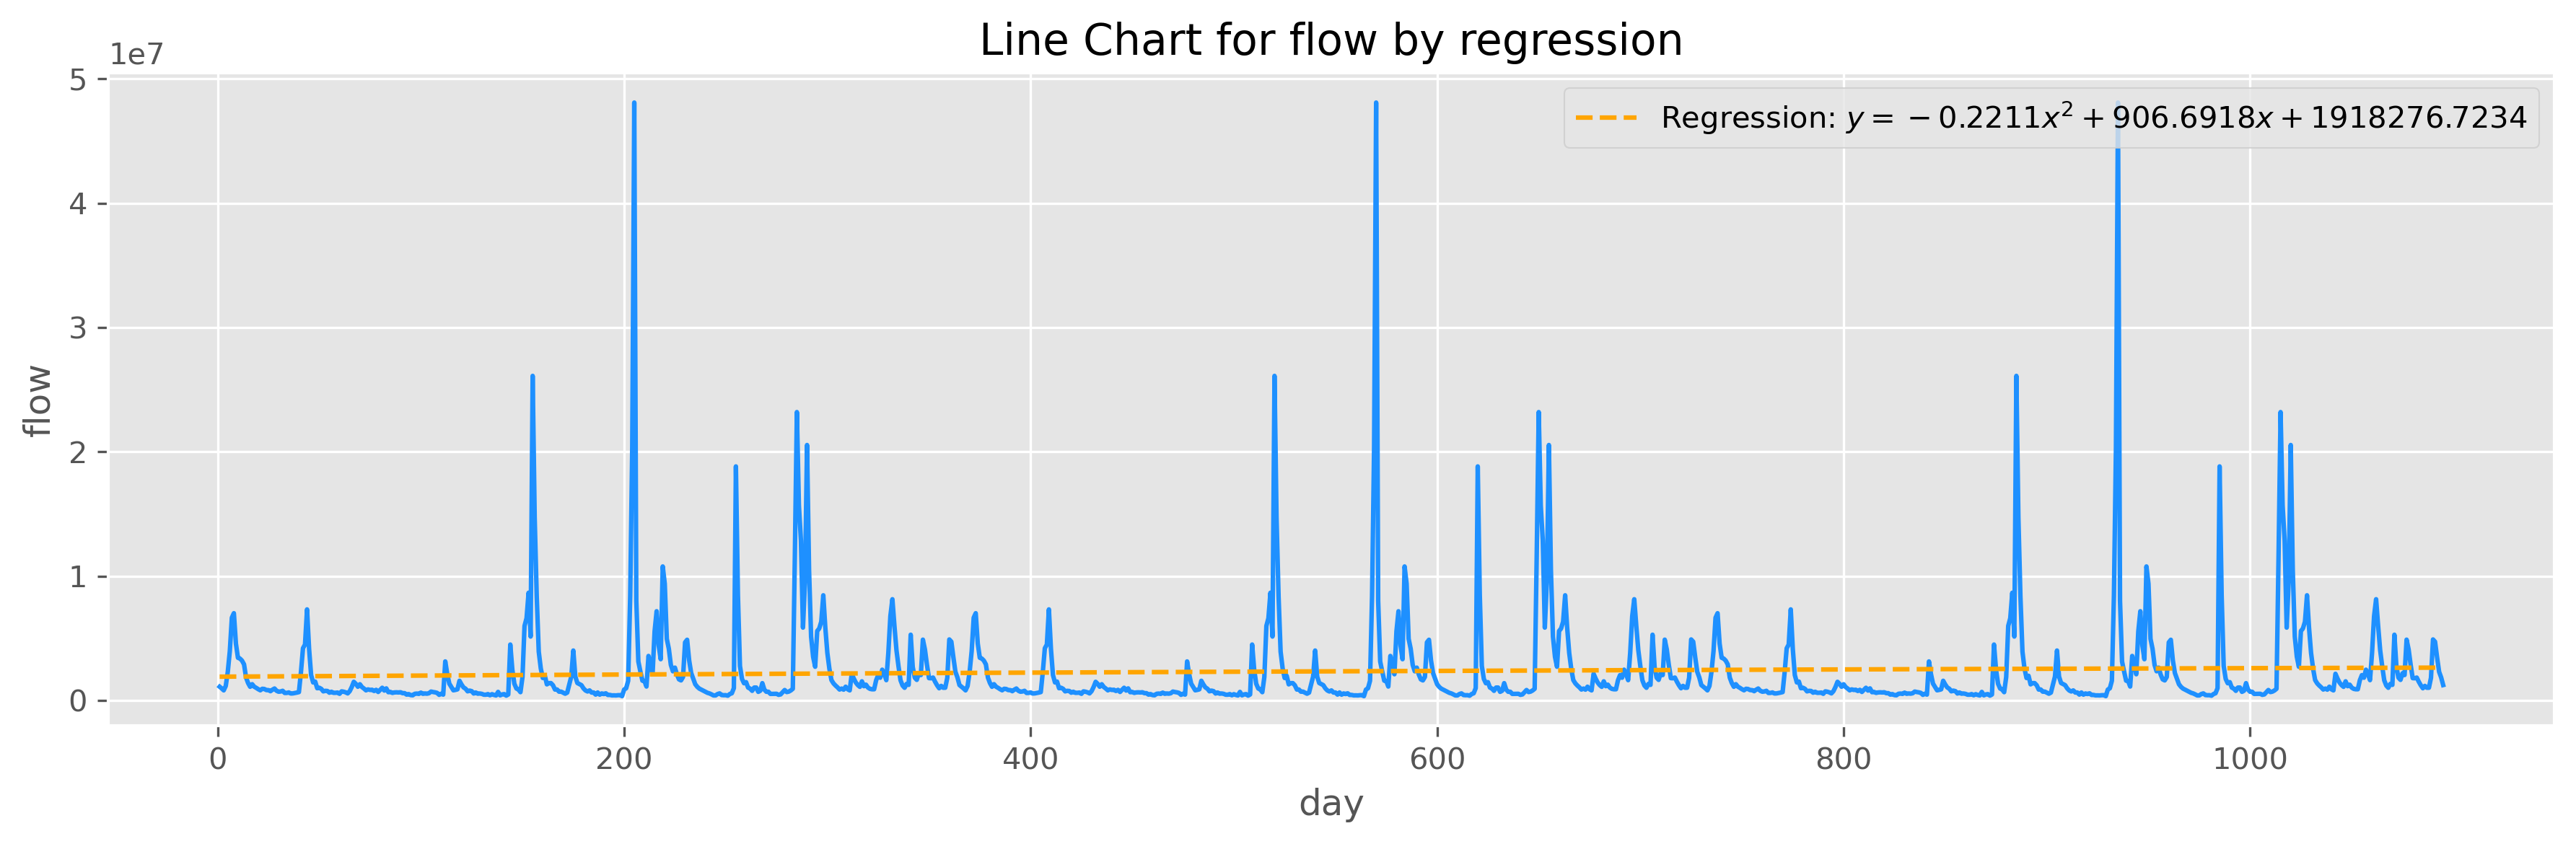

In [15]:
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize = (12,4))

label = f'Regression: $y = {a:.4f} x^2 + {b:.4f} x + {c:.4f}$'
#plt.scatter(x_var, y_var, color='dodgerblue')
plt.plot(x_var, y_var, color='dodgerblue')
x_line = np.arange(min(x_var), max(x_var), 1)
y_line = np.polyval(fitParams, x_line)
plt.plot(x_line, y_line, '--', color='orange', label=label)
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.legend()
plt.title('Line Chart for flow by regression')
fig.tight_layout()
plt.show()

# np.polyval(fitParams, 40)

In [16]:
forecast_df[y_name] = forecast_df[y_name].astype('float64')
measurements = ['MA(3)', 'ES(0.8)', 'EST(0.8, 0.2, 1109556.0, 1)','Regression']
err_df, style_df = error_metric(df=forecast_df, measurements=measurements, y_name=y_name)
err_df

### Error Metrics - MA(3)
MAD = 1451318.8620
MSE = 14909294762293.5742
RMSE = 3861255.5940
MAPE = 44.5929%

### Error Metrics - ES(0.8)
MAD = 1204778.4013
MSE = 12304966479245.6953
RMSE = 3507843.5654
MAPE = 31.6474%

### Error Metrics - EST(0.8, 0.2, 1109556.0, 1)
MAD = 1330577.2947
MSE = 14540613270741.0566
RMSE = 3813215.6077
MAPE = 36.3235%

### Error Metrics - Regression
MAD = 2092365.1119
MSE = 16395643025915.1680
RMSE = 4049153.3715
MAPE = 161.2564%



,MA(3),ES(0.8),"EST(0.8, 0.2, 1109556.0, 1)",Regression
MAD,1.451319e+06,1.204778e+06,1.330577e+06,2.092365e+06
MSE,1.490929e+13,1.230497e+13,1.454061e+13,1.639564e+13
RMSE,3.861256e+06,3.507844e+06,3.813216e+06,4.049153e+06
MAPE,4.459287e+01,3.164738e+01,3.632350e+01,1.612564e+02


In [17]:
ans = """Quartiles:
{}
---

""".format(outlier(df_new["flow"].dropna(), show=False)[1])

# outlier will show Q1, Q2, Q3, IQR, and Outliers

print(ans) 

Quartiles:

Q1 = 659924.0
Q2 = 1024992.0
Q3 = 2113000.0
IQR = 1453076.0

Outliers are listed as follows:
[6659748.0, 7023240.0, 4575376.0, 4503000.0, 7330000.0, 4502000.0, 6000000.0, 6616000.0, 8667000.0, 5145250.0, 26109000.0, 14725000.0, 8385000.0, 8409284.0, 20353896.0, 48091640.0, 8029000.0, 5562932.0, 7180860.0, 4443832.0, 10782856.0, 9395312.0, 4961716.0, 4676980.0, 4886328.0, 18827944.0, 8484876.0, 11561292.0, 23197504.0, 15702348.0, 12862060.0, 5862980.0, 9635100.0, 20549920.0, 10485600.0, 5135664.0, 5588712.0, 5792900.0, 6340620.0, 8463328.0, 5847672.0, 6782748.0, 8147260.0, 5996784.0, 5292872.0, 4894608.0, 4911956.0, 4729660.0, 6659748.0, 7023240.0, 4575376.0, 4503000.0, 7330000.0, 4502000.0, 6000000.0, 6616000.0, 8667000.0, 5145250.0, 26109000.0, 14725000.0, 8385000.0, 8409284.0, 20353896.0, 48091640.0, 8029000.0, 5562932.0, 7180860.0, 4443832.0, 10782856.0, 9395312.0, 4961716.0, 4676980.0, 4886328.0, 18827944.0, 8484876.0, 11561292.0, 23197504.0, 15702348.0, 12862060.0, 586

In [19]:
Q1 = 658706.0
Q2 = 1024992.0
Q3 = 2114598.0
IQR = 1455892.0
UF = Q3 + 1.5*IQR
df_new["adj_flow"] = df_new["flow"]
for i in range(365):
      if(df_new["adj_flow"][i] > UF):
            df_new["adj_flow"][i] = Q2

<ipython-input-19-83848e5e5c03>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["adj_flow"][i] = Q2


,day,adj_flow,MA(3),flow,ES(0.8),"EST(0.8, 0.2, 1109556.0, 1)",Regression
0,1,1.10956e+06,NaN,1.10956e+06,1.109556e+06,1.109557e+06,8.011425e+05
1,2,974520,NaN,974520,1.109556e+06,1.109557e+06,8.036962e+05
2,3,817460,NaN,817460,1.001527e+06,9.799223e+05,8.062487e+05
3,4,1.16899e+06,9.671787e+05,1.16899e+06,8.542734e+05,8.023534e+05,8.087999e+05
4,5,2.30677e+06,9.869907e+05,2.30677e+06,1.106048e+06,1.106727e+06,8.113498e+05
...,...,...,...,...,...,...,...
1091,1092,3.47315e+06,3.821808e+06,3.47315e+06,4.636274e+06,5.287576e+06,2.845978e+06
1092,1093,2.31005e+06,4.371589e+06,2.31005e+06,3.705776e+06,4.085927e+06,2.847172e+06
1093,1094,1.85781e+06,3.504287e+06,1.85781e+06,2.589194e+06,2.630973e+06,2.848364e+06
1094,1095,1.24446e+06,2.547003e+06,1.24446e+06,2.004085e+06,1.854484e+06,2.849555e+06


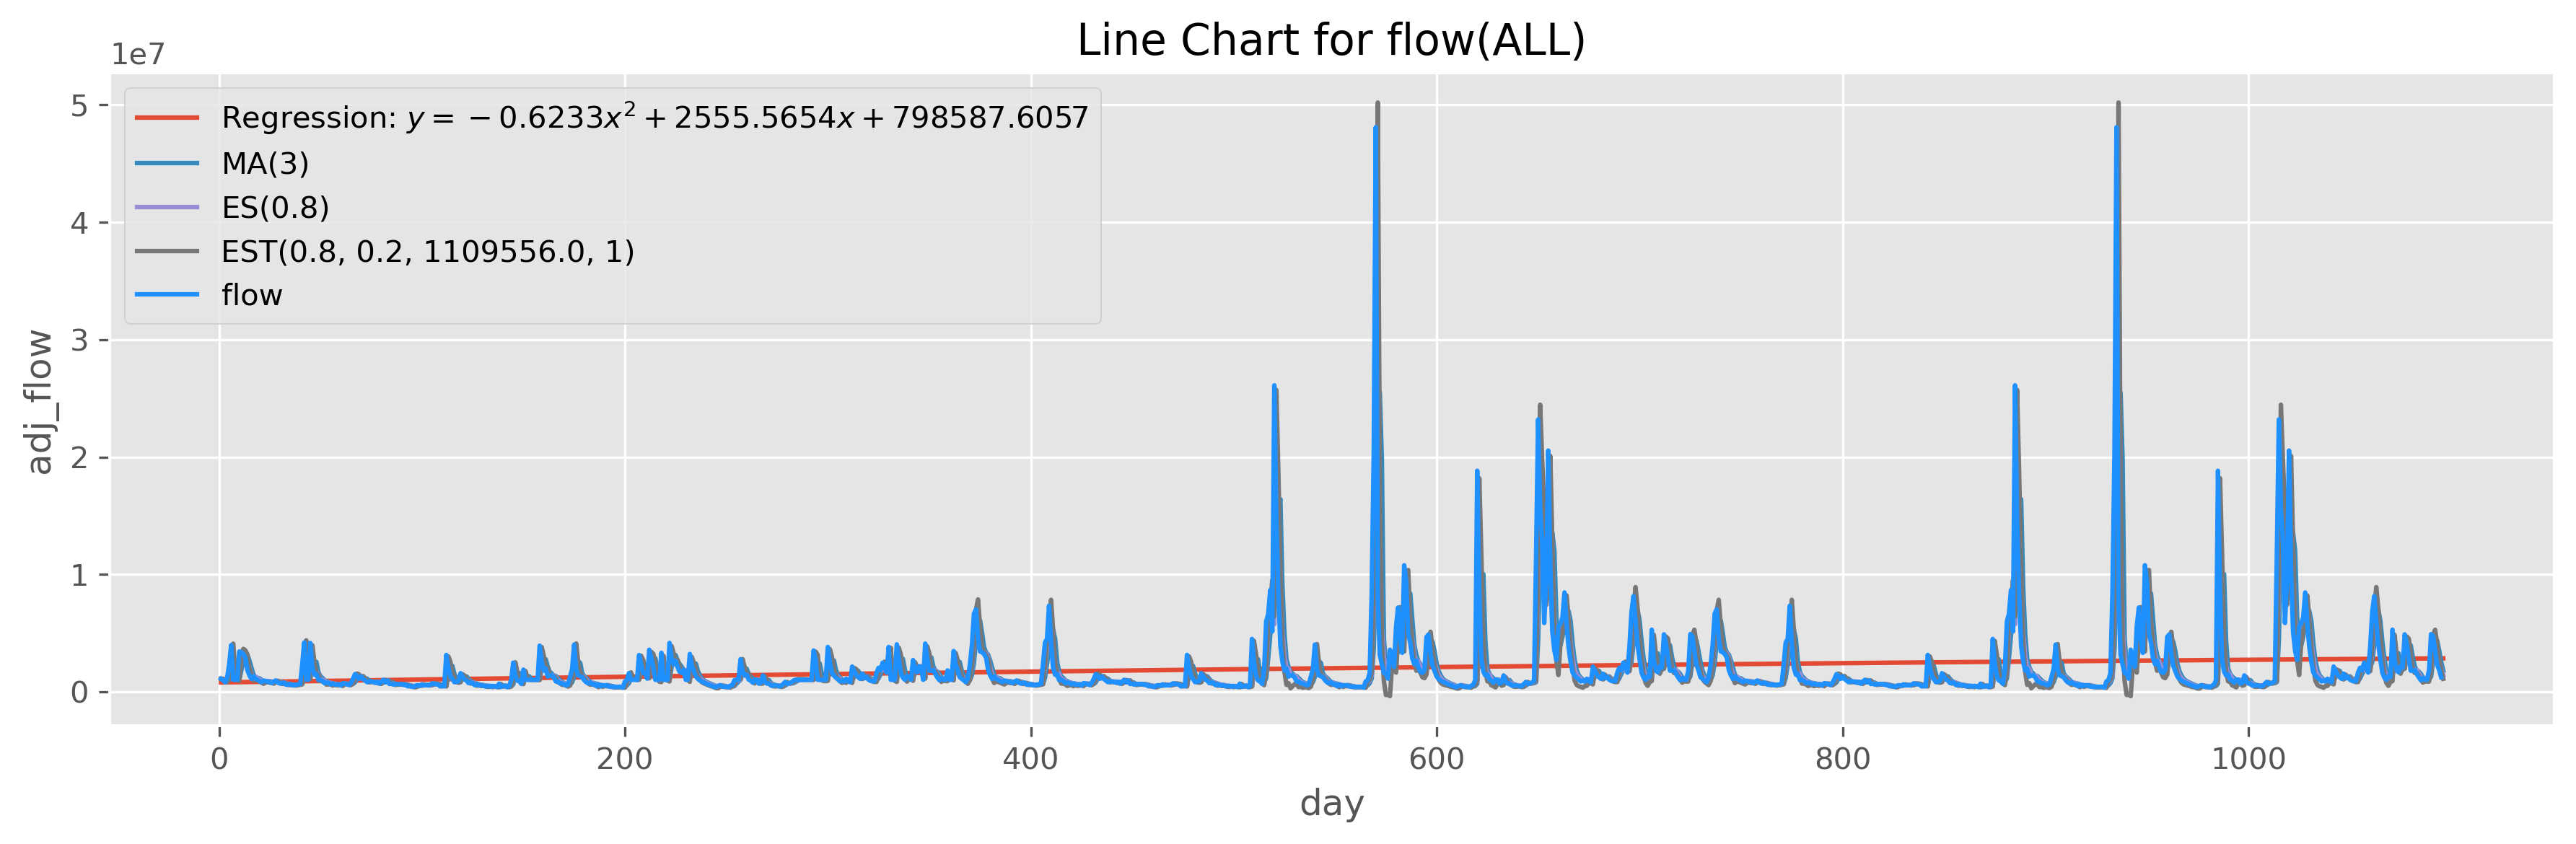

In [21]:
plt.rcParams["figure.dpi"] = 300
fig = plt.figure(figsize = (12,4))
y_name="adj_flow"
x_name="day"
y_var = df_new[y_name].values
x_var = df_new[x_name].values
y_var = y_var.astype('float64')
# MA
forecast_df_adj = mav(df_new, 3, y_name=y_name, time_name=x_name)
# exp smoothin
alpha = 0.8
forecast_df_adj = forecast_df_adj.merge(exp_smoothing(df=df_new, alpha=alpha, y_name=y_name, time_name=x_name))
# exp trend
forecast_df_adj = forecast_df_adj.merge(exp_trend(df=df_new, alpha=0.8, beta=0.2, average=y_var[0], trend=1, n=2, y_name=y_name, time_name=x_name))

# regression
fitParams = np.polyfit(x_var, y_var, 2)
a, b, c = fitParams
forecast_df_adj['Regression'] = np.polyval(fitParams, list(forecast_df_adj[x_name]))
# Plot
f_col = ['MA(3)', 'ES(0.8)', 'EST(0.8, 0.2, 1109556.0, 1)']

label = f'Regression: $y = {a:.4f} x^2 + {b:.4f} x + {c:.4f}$'
x_line = forecast_df_adj[x_name].values
y_line = np.polyval(fitParams, x_line)
plt.plot(x_line, y_line, label=label)

for f in f_col:
    y_line = forecast_df_adj[f][:len(x_line)]
    plt.plot(x_line, y_line, label=f)

display(forecast_df_adj)

# data

plt.plot(x_var, y_var, color='dodgerblue', label='flow')
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.legend()
plt.title('Line Chart for flow(ALL)') 
fig.tight_layout()


plt.show()

In [22]:
forecast_df_adj[y_name] = forecast_df_adj[y_name].astype('float64')
measurements = ['MA(3)', 'ES(0.8)', 'EST(0.8, 0.2, 1109556.0, 1)','Regression']
err_df, style_df = error_metric(df=forecast_df_adj, measurements=measurements, y_name=y_name)
err_df

### Error Metrics - MA(3)
MAD = 1116083.5995
MSE = 10129902788844.1953
RMSE = 3182750.8210
MAPE = 39.9832%

### Error Metrics - ES(0.8)
MAD = 934310.8630
MSE = 8385837670880.3975
RMSE = 2895831.0847
MAPE = 29.6956%

### Error Metrics - EST(0.8, 0.2, 1109556.0, 1)
MAD = 1032479.7817
MSE = 9909595124376.9707
RMSE = 3147950.9406
MAPE = 33.6685%

### Error Metrics - Regression
MAD = 1574403.1144
MSE = 11110182245515.2402
RMSE = 3333194.0006
MAPE = 124.7820%



,MA(3),ES(0.8),"EST(0.8, 0.2, 1109556.0, 1)",Regression
MAD,1.116084e+06,9.343109e+05,1.032480e+06,1.574403e+06
MSE,1.012990e+13,8.385838e+12,9.909595e+12,1.111018e+13
RMSE,3.182751e+06,2.895831e+06,3.147951e+06,3.333194e+06
MAPE,3.998318e+01,2.969555e+01,3.366855e+01,1.247820e+02
